In [216]:
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# For regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# For model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [218]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Support Vector Regressor': SVR()
}

In [219]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC()
}

# Preparing a dataset

## Actigraphy dataset

In [220]:
actigraphy_df = pd.read_parquet("series_train.parquet")

In [221]:
# Removing irrelevant columns
actigraphy_df.drop(
    columns=["step", "X", "Y", "Z", "anglez", "battery_voltage"],
    inplace=True,
)

In [222]:
# Adding mean, median, and std columns
agg_funcs = {
    "enmo": ["mean", "std"],
    "non-wear_flag": ["mean", "std"],
    "light": ["mean", "std"]
}

actigraphy_df = actigraphy_df.groupby("id", observed=True).agg(agg_funcs)
actigraphy_df.columns = ['_'.join(col).strip() for col in actigraphy_df.columns.values]
actigraphy_df.reset_index(inplace=True)
display(actigraphy_df)

,id,enmo_mean,enmo_std,non-wear_flag_mean,non-wear_flag_std,light_mean,light_std
0,00115b9f,0.047388,0.106351,0.000000,0.000000,42.296310,208.168976
1,001f3379,0.011926,0.024331,0.655708,0.468723,16.771980,95.327438
2,00f332d1,0.030255,0.104136,0.171246,0.374121,66.563393,286.916595
3,01085eb3,0.032946,0.083798,0.035210,0.183652,17.800735,73.023468
4,012cadd8,0.058280,0.197285,0.000000,0.000000,54.893402,230.972397
...,...,...,...,...,...,...,...
991,fe9c71d8,0.043686,0.103688,0.137257,0.340731,7.297878,33.701969
992,fecc07d6,0.002962,0.012999,0.939101,0.231608,50.648312,86.377480
993,ff18b749,0.053595,0.142568,0.000000,0.000000,94.217117,312.745941
994,ffcd4dbd,0.028601,0.072386,0.020323,0.139045,22.480034,110.340538


In [223]:
actigraphy_df.columns

Index(['id', 'enmo_mean', 'enmo_std', 'non-wear_flag_mean',
       'non-wear_flag_std', 'light_mean', 'light_std'],
      dtype='object')

In [224]:
# # Taking means after aggregations
# actigraphy_df = actigraphy_df.groupby("id", observed=True).agg(
#     {"enmo": "mean", "non-wear_flag": "mean", "light": "mean"}
# )

# actigraphy_df.reset_index(inplace=True)
# display(actigraphy_df)

## HBN dataset

In [373]:
hbn_df = pd.read_csv("train.csv")

In [374]:
# Converting seasons to numeric values
season_mapping = {"Spring": 0, "Summer": 1, "Fall": 2, "Winter": 3}
season_cols = hbn_df.filter(regex="Season$").columns
hbn_df[season_cols] = hbn_df[season_cols].replace(season_mapping)

/var/folders/zx/vckbd4yn4t7bb1hlf2w83w5c0000gn/T/ipykernel_6493/2726629741.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hbn_df[season_cols] = hbn_df[season_cols].replace(season_mapping)


### Valid range

In [375]:
valid_ranges = {
    'Basic_Demos-Enroll_Season': (0, 3),
    'Basic_Demos-Age': (0, 120),
    'Basic_Demos-Sex': (0, 1),
    'CGAS-Season': (0, 3),
    'CGAS-CGAS_Score': (0, 100),
    'Physical-Season': (0, 3),
    'Physical-BMI': (10, 60),
    'Physical-Height': (30, 250),
    'Physical-Weight': (2, 300),
    'Physical-Waist_Circumference': (10, 200),
    'Physical-Diastolic_BP': (30, 120),
    'Physical-HeartRate': (30, 200),
    'Physical-Systolic_BP': (50, 250),
    'Fitness_Endurance-Season': (0, 3),
    'Fitness_Endurance-Max_Stage': (0, 20),
    'Fitness_Endurance-Time_Mins': (0, 60),
    'Fitness_Endurance-Time_Sec': (0, 60),
    'FGC-Season': (0, 3),
    'FGC-FGC_CU': (0, 100),
    'FGC-FGC_CU_Zone': (0, 3),
    'FGC-FGC_GSND': (0, 100),
    'FGC-FGC_GSND_Zone': (0, 3),
    'FGC-FGC_GSD': (0, 100),
    'FGC-FGC_GSD_Zone': (0, 3),
    'FGC-FGC_PU': (0, 100),
    'FGC-FGC_PU_Zone': (0, 3),
    'FGC-FGC_SRL': (0, 100),
    'FGC-FGC_SRL_Zone': (0, 3),
    'FGC-FGC_SRR': (0, 100),
    'FGC-FGC_SRR_Zone': (0, 3),
    'FGC-FGC_TL': (0, 100),
    'FGC-FGC_TL_Zone': (0, 3),
    'BIA-Season': (0, 3),
    'BIA-BIA_Activity_Level_num': (0, 5),
    'BIA-BIA_BMC': (0, 10),
    'BIA-BIA_BMI': (10, 60),
    'BIA-BIA_BMR': (500, 3000),
    'BIA-BIA_DEE': (1000, 5000),
    'BIA-BIA_ECW': (0, 50),
    'BIA-BIA_FFM': (0, 100),
    'BIA-BIA_FFMI': (0, 50),
    'BIA-BIA_FMI': (0, 50),
    'BIA-BIA_Fat': (0, 100),
    'BIA-BIA_Frame_num': (0, 5),
    'BIA-BIA_ICW': (0, 50),
    'BIA-BIA_LDM': (0, 50),
    'BIA-BIA_LST': (0, 100),
    'BIA-BIA_SMM': (0, 100),
    'BIA-BIA_TBW': (0, 100),
    'PAQ_A-Season': (0, 3),
    'PAQ_A-PAQ_A_Total': (0, 10),
    'PAQ_C-Season': (0, 3),
    'PAQ_C-PAQ_C_Total': (0, 10),
    'PCIAT-Season': (0, 3),
    'PCIAT-PCIAT_01': (0, 5),
    'PCIAT-PCIAT_02': (0, 5),
    'PCIAT-PCIAT_03': (0, 5),
    'PCIAT-PCIAT_04': (0, 5),
    'PCIAT-PCIAT_05': (0, 5),
    'PCIAT-PCIAT_06': (0, 5),
    'PCIAT-PCIAT_07': (0, 5),
    'PCIAT-PCIAT_08': (0, 5),
    'PCIAT-PCIAT_09': (0, 5),
    'PCIAT-PCIAT_10': (0, 5),
    'PCIAT-PCIAT_11': (0, 5),
    'PCIAT-PCIAT_12': (0, 5),
    'PCIAT-PCIAT_13': (0, 5),
    'PCIAT-PCIAT_14': (0, 5),
    'PCIAT-PCIAT_15': (0, 5),
    'PCIAT-PCIAT_16': (0, 5),
    'PCIAT-PCIAT_17': (0, 5),
    'PCIAT-PCIAT_18': (0, 5),
    'PCIAT-PCIAT_19': (0, 5),
    'PCIAT-PCIAT_20': (0, 5),
    'PCIAT-PCIAT_Total': (0, 100),
    'SDS-Season': (0, 3),
    'SDS-SDS_Total_Raw': (0, 100),
    'SDS-SDS_Total_T': (0, 100),
    'PreInt_EduHx-Season': (0, 3),
    'PreInt_EduHx-computerinternet_hoursday': (0, 24),
    'sii': (0, 3)
}

for column, (min_val, max_val) in valid_ranges.items():
    hbn_df.loc[(hbn_df[column] < min_val) | (hbn_df[column] > max_val), column] = np.nan

In [376]:
# As sii column is calculated from PCIAT Total and that is calculated from PCIAT questions, we can drop all PCIAT columns. We will only keep the season column
columns_to_drop = hbn_df.filter(regex="^PCIAT").columns.difference(["PCIAT-Season"])
hbn_df.drop(columns=columns_to_drop, inplace=True)

In [377]:
age_groups = sorted(hbn_df['Basic_Demos-Age'].unique().tolist())

### BMI

In [378]:
hbn_df['Physical-BMI'] = hbn_df['Physical-BMI'].fillna(hbn_df['BIA-BIA_BMI'])

In [379]:
# That did not make a huge difference so we will drop one of the columns and will the value in a different way
hbn_df.drop(columns=['BIA-BIA_BMI'], inplace=True)

In [380]:
column_of_interest = 'Physical-BMI'
for age in age_groups:
    age_group_df = hbn_df[hbn_df['Basic_Demos-Age'] == age].dropna(subset=[column_of_interest])
    if len(age_group_df) < 20:
        continue
    Q1 = age_group_df[column_of_interest].quantile(0.25)
    Q3 = age_group_df[column_of_interest].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = age_group_df[(age_group_df[column_of_interest] >= lower_bound) & (age_group_df[column_of_interest] <= upper_bound)]
    median_value = filtered_df[column_of_interest].median()
    hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest] = hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest].fillna(median_value)
    hbn_df = hbn_df[~((hbn_df['Basic_Demos-Age'] == age) & ((hbn_df[column_of_interest] < lower_bound) | (hbn_df[column_of_interest] > upper_bound)))]

### BIA

In [381]:
columns_of_interest = hbn_df.filter(regex='^BIA').columns.to_list()
columns_of_interest.remove('BIA-Season')
columns_of_interest.remove('BIA-BIA_Activity_Level_num')
columns_of_interest.remove('BIA-BIA_Frame_num')
bia_corr_columns = ['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight']

In [382]:
results = {}
for col in columns_of_interest:
    training_df = hbn_df.copy().dropna(subset=[col] + bia_corr_columns)

    X = training_df[bia_corr_columns].values
    y = training_df[col].values

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    results[col] = []

    for model_name, model in regression_models.items():
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        y_test_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        results[col].append({
            'Model': model_name,
            'Validation MSE': val_mse,
            'Validation R²': val_r2,
            'Test MSE': test_mse,
            'Test R²': test_r2
        })

best_models = {}
for col, result in results.items():
    best_model = max(result, key=lambda x: (x['Validation R²'], x['Test R²']))
    if best_model['Validation R²'] > 0.7 and best_model['Test R²'] > 0.7:
        best_models[col] = best_model['Model']

for col, best_model in best_models.items():
    print(f"Column: {col}, Model: {best_model}")
    training_df = hbn_df.copy().dropna(subset=[col] + bia_corr_columns)

    prediction_df = hbn_df[hbn_df[col].isnull()]
    prediction_df = prediction_df.dropna(subset=bia_corr_columns)

    X = training_df[bia_corr_columns].values
    y = training_df[col].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = regression_models[best_model]
    model.fit(X_train, y_train)
    print(f"Score: {model.score(X_test, y_test)}")

    for index, row in prediction_df.iterrows():
        X = row[bia_corr_columns].values.reshape(1, -1)
        prediction = model.predict(X)
        hbn_df.loc[index, col] = prediction

Column: BIA-BIA_BMR, Model: Lasso Regression
Score: 0.8976876365422236
Column: BIA-BIA_ECW, Model: Linear Regression
Score: 0.9014181157084104
Column: BIA-BIA_FFM, Model: Gradient Boosting Regressor
Score: 0.934502844635216
Column: BIA-BIA_Fat, Model: Gradient Boosting Regressor
Score: 0.8987728875925107
Column: BIA-BIA_ICW, Model: Gradient Boosting Regressor
Score: 0.746650377935171
Column: BIA-BIA_LDM, Model: Ridge Regression
Score: 0.8892592612722048
Column: BIA-BIA_LST, Model: Gradient Boosting Regressor
Score: 0.9296166801831494
Column: BIA-BIA_SMM, Model: Lasso Regression
Score: 0.7940393975924847
Column: BIA-BIA_TBW, Model: Linear Regression
Score: 0.9078853946345324


### Waist

In [383]:
# Getting correlation columns
correlation_matrix = hbn_df.drop(columns=['id']).corr()
waist_corr = correlation_matrix['Physical-Waist_Circumference']
waist_corr_columns = waist_corr[waist_corr.abs() > 0.5].index.tolist()
waist_corr_columns.remove('Physical-Waist_Circumference')
waist_corr_columns.remove('BIA-BIA_DEE')
waist_corr_columns.remove('BIA-BIA_FFMI')
waist_corr_columns.remove('Physical-BMI')

In [384]:
training_df = hbn_df.copy()
training_df.dropna(subset=waist_corr_columns + ['Physical-Waist_Circumference'], inplace=True)
prediction_df = hbn_df[hbn_df['Physical-Waist_Circumference'].isnull()].dropna(subset=waist_corr_columns)

In [385]:
X = training_df[waist_corr_columns].values
y = training_df['Physical-Waist_Circumference'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [386]:
results = []

for model_name, model in regression_models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': model_name,
        'Validation MSE': val_mse,
        'Validation R²': val_r2,
        'Test MSE': test_mse,
        'Test R²': test_r2
    })

results_df = pd.DataFrame(results)
display(results_df)

,Model,Validation MSE,Validation R²,Test MSE,Test R²
0,Linear Regression,2.470500,0.879315,2.809118,0.886329
1,Ridge Regression,2.461962,0.879732,2.797568,0.886796
2,Lasso Regression,2.792159,0.863602,3.050816,0.876549
3,Decision Tree Regressor,4.604592,0.775064,9.255102,0.625492
4,Random Forest Regressor,2.603872,0.872800,3.571562,0.855477
5,Gradient Boosting Regressor,2.944226,0.856173,3.683559,0.850945
6,K-Nearest Neighbors Regressor,4.058061,0.801762,5.258367,0.787220
7,Support Vector Regressor,6.529438,0.681034,8.532760,0.654722


In [387]:
best_model = results_df.loc[results_df['Test R²'].idxmax() & results_df['Validation R²'].idxmax()]
print("\nBest Model:")
print(best_model)


Best Model:
Model             Ridge Regression
Validation MSE            2.461962
Validation R²             0.879732
Test MSE                  2.797568
Test R²                   0.886796
Name: 1, dtype: object


In [388]:
model = regression_models[best_model['Model']]
model.fit(X_train, y_train)

Ridge()

In [389]:
for index, row in prediction_df.iterrows():
    X = row[waist_corr_columns].values.reshape(1, -1)
    waist = model.predict(X)
    hbn_df.loc[index, 'Physical-Waist_Circumference'] = waist

In [390]:
column_of_interest = 'Physical-Waist_Circumference'
for age in age_groups:
    age_group_df = hbn_df[hbn_df['Basic_Demos-Age'] == age].dropna(subset=[column_of_interest])
    if len(age_group_df) < 20:
        continue
    Q1 = age_group_df[column_of_interest].quantile(0.25)
    Q3 = age_group_df[column_of_interest].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = age_group_df[(age_group_df[column_of_interest] >= lower_bound) & (age_group_df[column_of_interest] <= upper_bound)]
    median_value = filtered_df[column_of_interest].median()
    hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest] = hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest].fillna(median_value)
    hbn_df = hbn_df[~((hbn_df['Basic_Demos-Age'] == age) & ((hbn_df[column_of_interest] < lower_bound) | (hbn_df[column_of_interest] > upper_bound)))]

### Diastolic and Systolic

In [391]:
# Setting the missing values to the median of the age group and dropping outliers
column_of_interest = 'Physical-Diastolic_BP'
for age in age_groups:
    age_group_df = hbn_df[hbn_df['Basic_Demos-Age'] == age].dropna(subset=[column_of_interest])
    if len(age_group_df) < 20:
        continue
    Q1 = age_group_df[column_of_interest].quantile(0.25)
    Q3 = age_group_df[column_of_interest].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = age_group_df[(age_group_df[column_of_interest] >= lower_bound) & (age_group_df[column_of_interest] <= upper_bound)]
    median_value = filtered_df[column_of_interest].median()
    hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest] = hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest].fillna(median_value)
    hbn_df = hbn_df[~((hbn_df['Basic_Demos-Age'] == age) & ((hbn_df[column_of_interest] < lower_bound) | (hbn_df[column_of_interest] > upper_bound)))]

column_of_interest = 'Physical-Systolic_BP'
for age in age_groups:
    age_group_df = hbn_df[hbn_df['Basic_Demos-Age'] == age].dropna(subset=[column_of_interest])
    if len(age_group_df) < 20:
        continue
    Q1 = age_group_df[column_of_interest].quantile(0.25)
    Q3 = age_group_df[column_of_interest].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = age_group_df[(age_group_df[column_of_interest] >= lower_bound) & (age_group_df[column_of_interest] <= upper_bound)]
    median_value = filtered_df[column_of_interest].median()
    hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest] = hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, column_of_interest].fillna(median_value)
    hbn_df = hbn_df[~((hbn_df['Basic_Demos-Age'] == age) & ((hbn_df[column_of_interest] < lower_bound) | (hbn_df[column_of_interest] > upper_bound)))]

### FGC

In [392]:
columns_of_interest = ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_TL']

In [393]:
for col in columns_of_interest:
    for age in age_groups:
        age_group_df = hbn_df[hbn_df['Basic_Demos-Age'] == age].dropna(subset=[col])
        if len(age_group_df) < 20:
            continue
        Q1 = age_group_df[col].quantile(0.25)
        Q3 = age_group_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_df = age_group_df[(age_group_df[col] >= lower_bound) & (age_group_df[col] <= upper_bound)]
        median_value = filtered_df[col].median()
        hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, col] = hbn_df.loc[hbn_df['Basic_Demos-Age'] == age, col].fillna(median_value)
        hbn_df = hbn_df[~((hbn_df['Basic_Demos-Age'] == age) & ((hbn_df[col] < lower_bound) | (hbn_df[col] > upper_bound)))]

### hbn rest

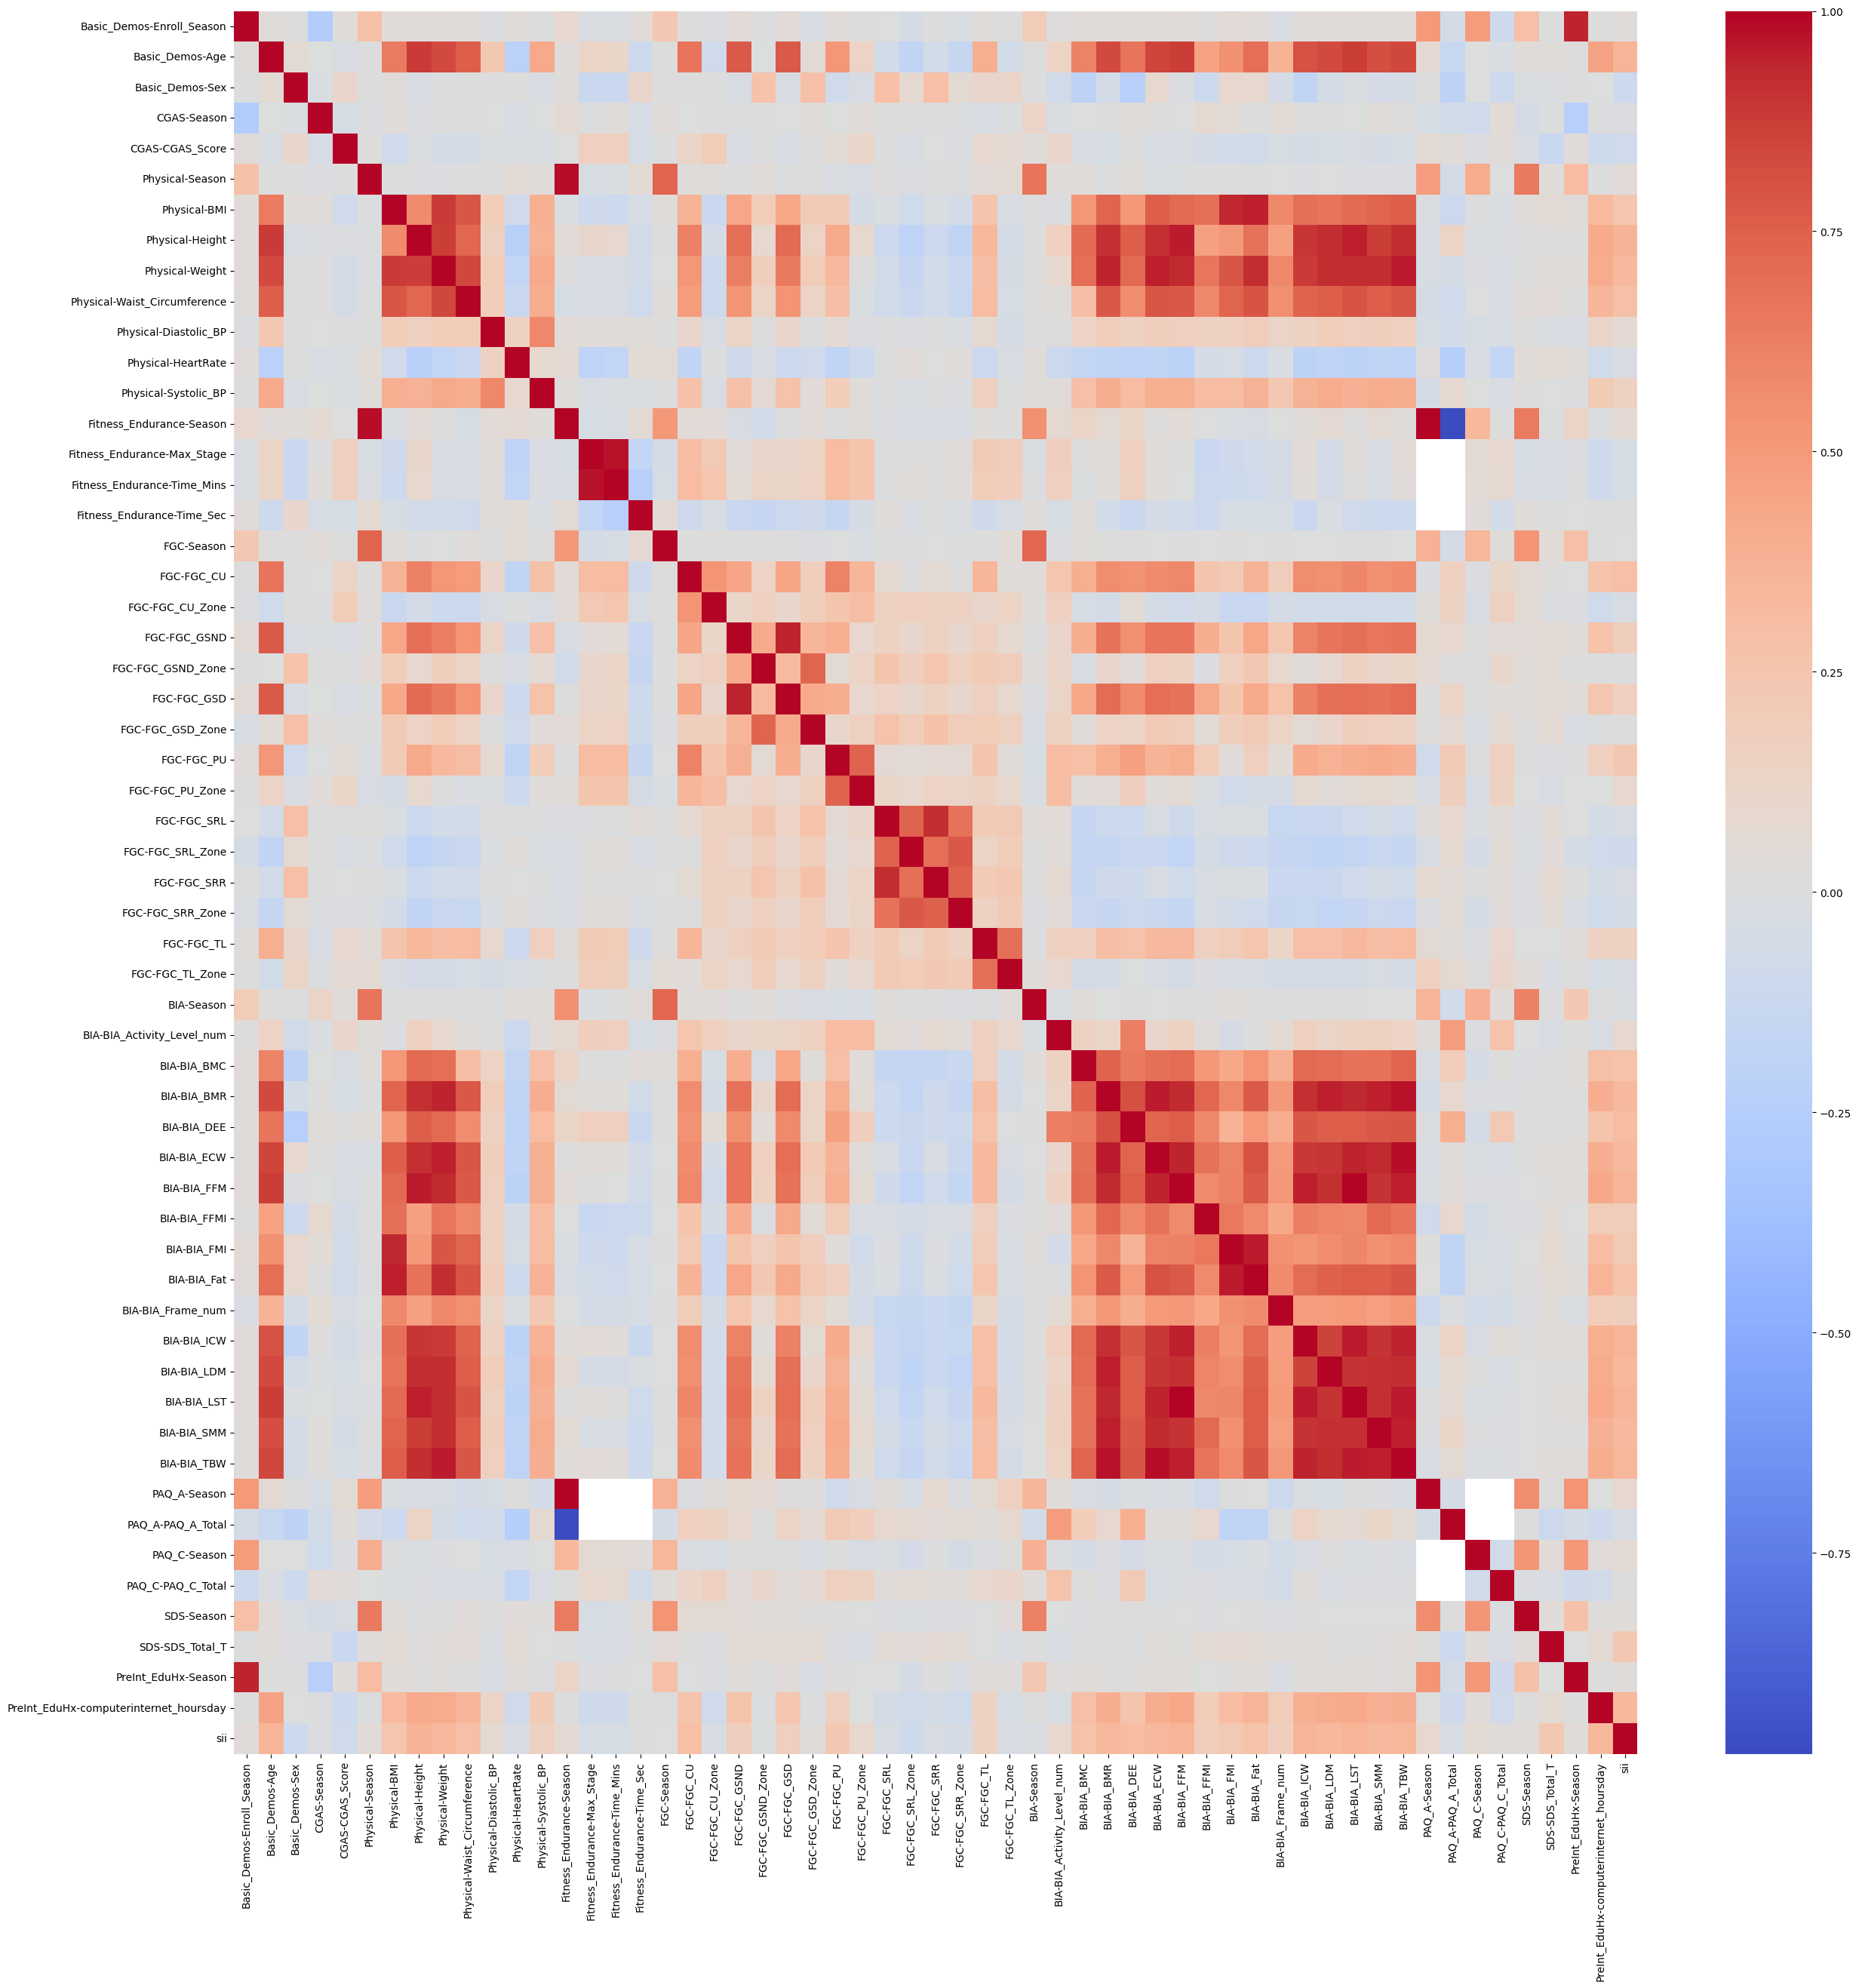

In [394]:
temp = hbn_df.copy()
temp.drop(columns=temp.filter(regex='^PCIAT').columns, inplace=True)
temp.drop(['id', 'SDS-SDS_Total_Raw'], axis=1, inplace=True)
correlation_matrix = temp.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

### Feature selection

In [395]:
correlation_matrix = hbn_df.drop(columns=['id']).corr()

sii_corr = correlation_matrix['sii']

sii_corr_columns = sii_corr[sii_corr.abs() > 0.2].index.tolist()
sii_corr_columns.remove('sii')

print("Columns that have correlation with sii:")
print(sii_corr_columns)

Columns that have correlation with sii:
['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'FGC-FGC_CU', 'FGC-FGC_PU', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday']


In [396]:
# Removing columns that we know are used to calculate others
sii_corr_columns.remove('Physical-Weight')
sii_corr_columns.remove('Physical-Height')
sii_corr_columns.remove('SDS-SDS_Total_Raw')
sii_corr_columns.remove('BIA-BIA_Fat')

In [397]:
hbn_df = hbn_df[sii_corr_columns + ['sii'] + ['id']]

In [398]:
hbn_df.dropna(inplace=True)

In [399]:
def hist_plots(df, cols):
    plt.figure(figsize=(20, 70))
    for i, col in enumerate(cols):
        plt.subplot(25, 5, i + 1)
        sns.histplot(df[col], kde=True)
        plt.xlabel(col)
        plt.title(col)
        plt.grid(True)
        plt.tight_layout()
    plt.show()

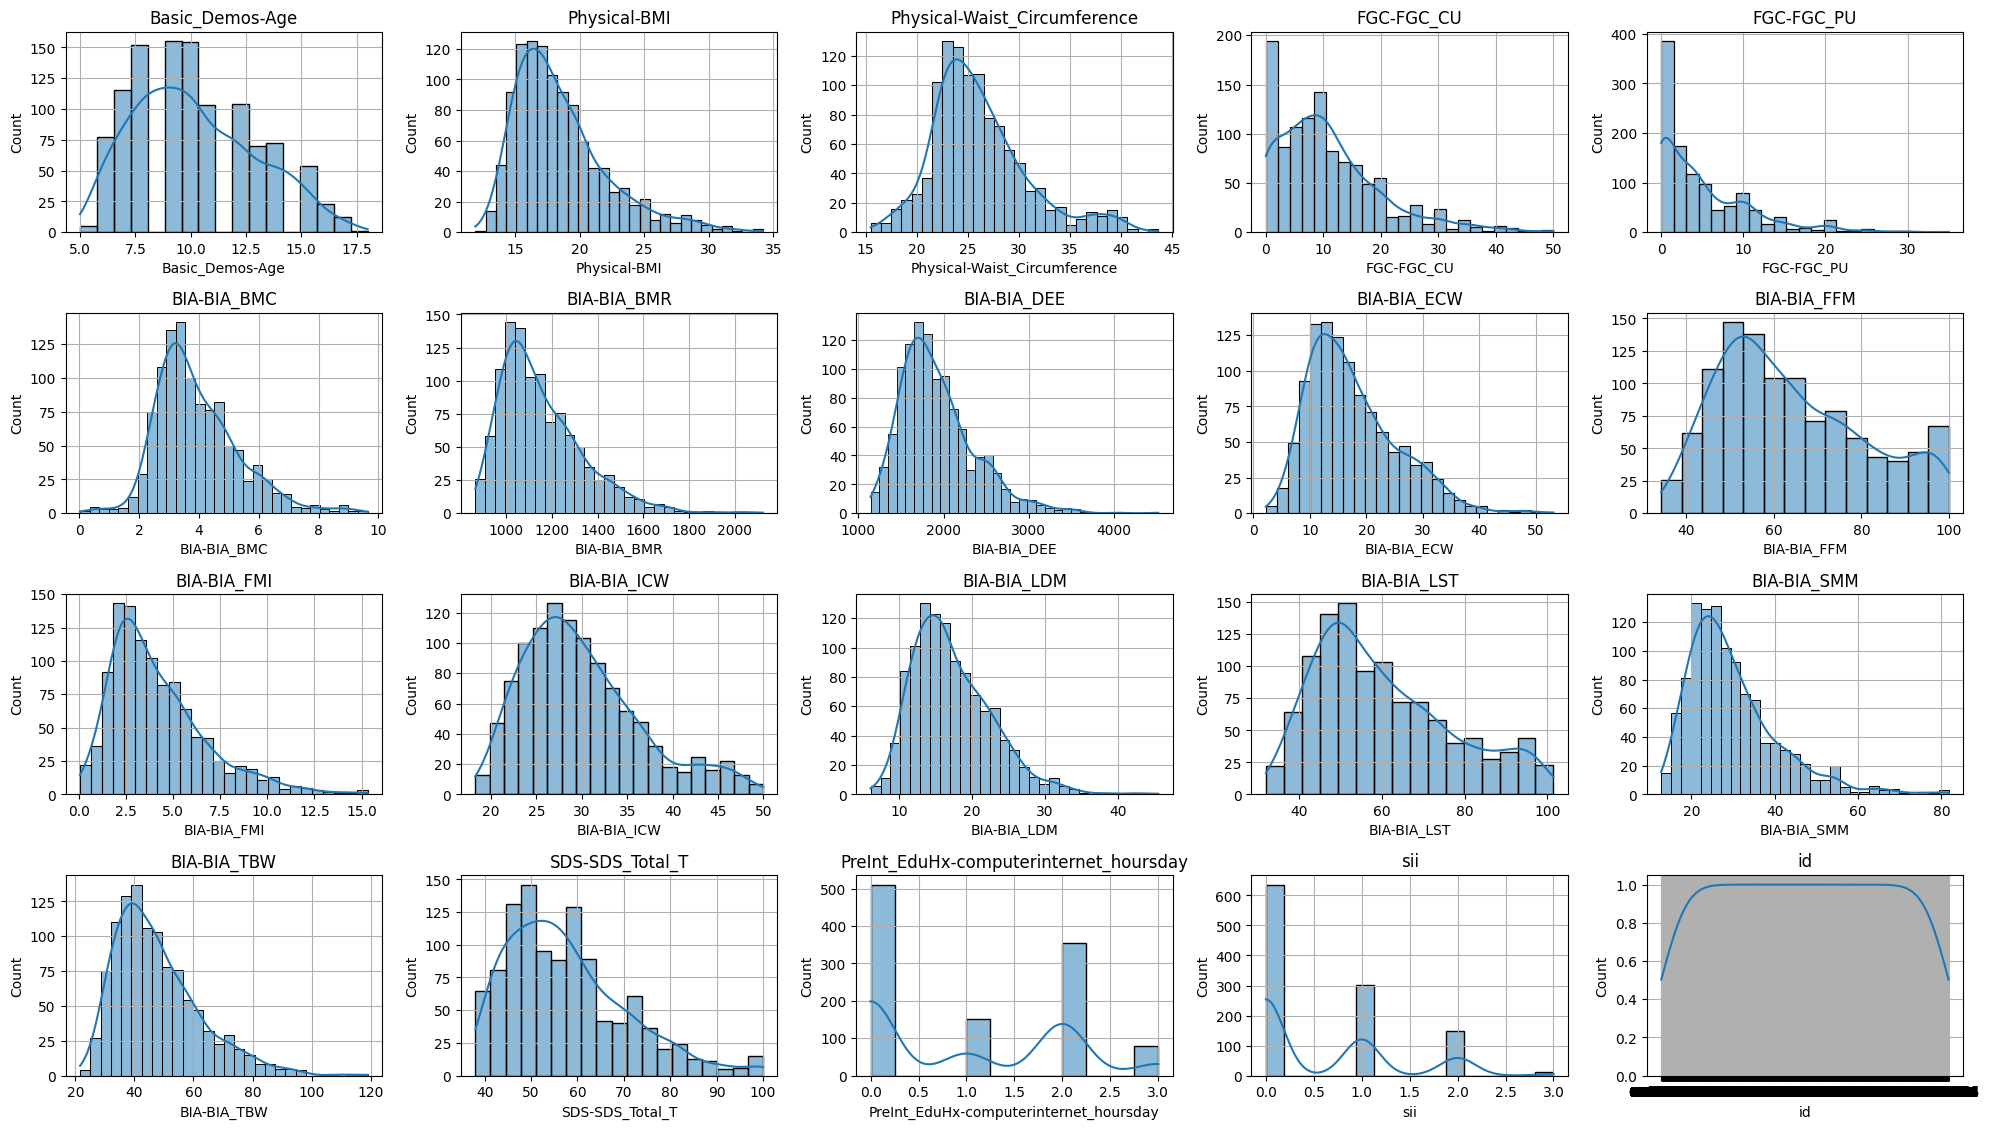

In [402]:
hist_plots(hbn_df, hbn_df.columns)

In [403]:
# We will do log over right skewed columns and then use a scalar over the data
def log_transform(df, col):
    # Replace zero or negative values with a small positive value before applying log
    df[col] = df[col].apply(lambda x: np.log(x) if x > 0 else np.log(1e-9))
    return df

columns_to_transform = ['Physical-BMI', 'Physical-Waist_Circumference', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FMI', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

for col in columns_to_transform:
    hbn_df = log_transform(hbn_df, col)

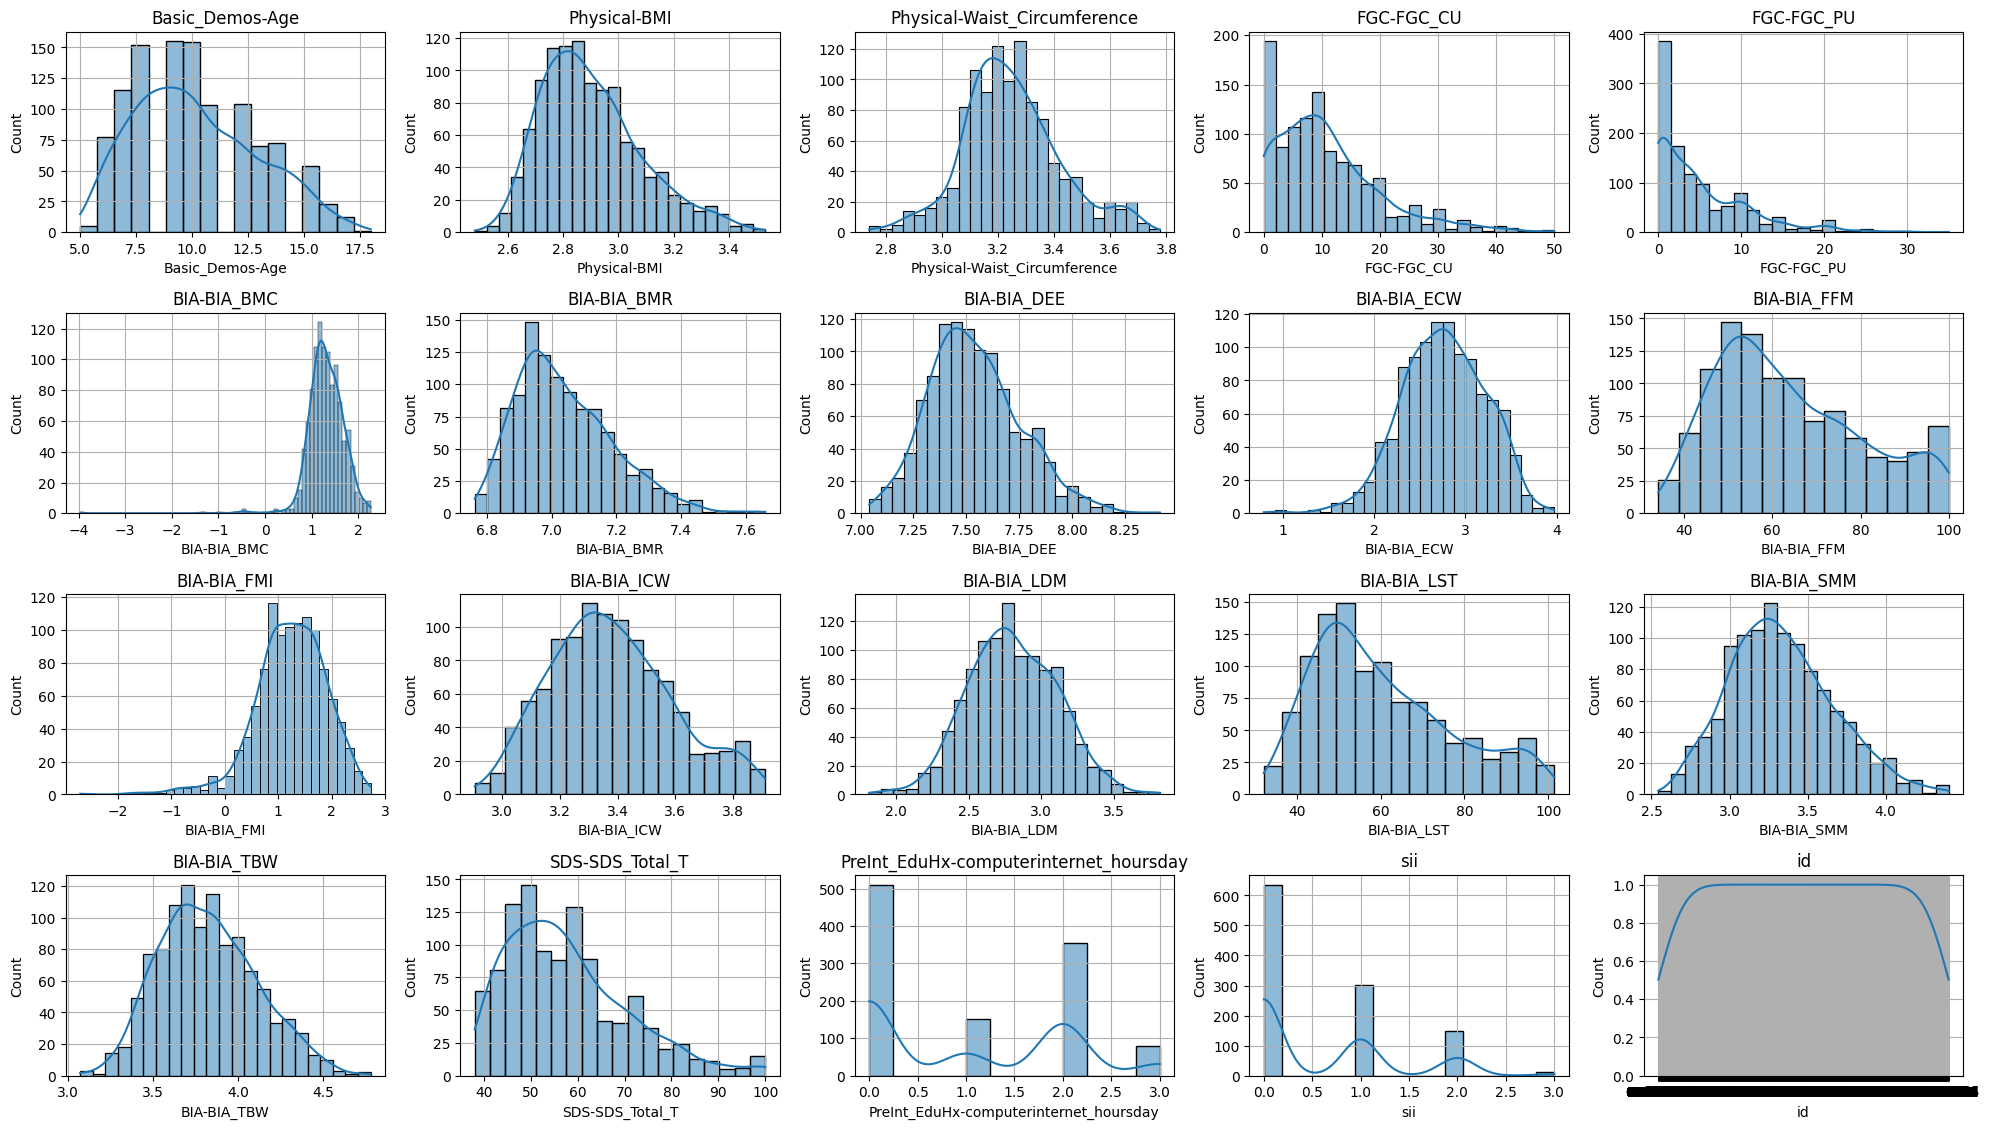

In [404]:
hist_plots(hbn_df, hbn_df.columns)

In [405]:
columns_to_min_max_scale = ['BIA-BIA_FFM', 'BIA-BIA_LST']
columns_to_standard_scale = ['FGC-FGC_CU', 'FGC-FGC_PU']

for col in columns_to_min_max_scale:
    scaler = MinMaxScaler()
    hbn_df[col] = scaler.fit_transform(hbn_df[col].values.reshape(-1, 1))

for col in columns_to_standard_scale:
    scaler = StandardScaler()
    hbn_df[col] = scaler.fit_transform(hbn_df[col].values.reshape(-1, 1))

In [406]:
hbn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1097 entries, 1 to 3957
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         1097 non-null   float64
 1   Physical-BMI                            1097 non-null   float64
 2   Physical-Waist_Circumference            1097 non-null   float64
 3   FGC-FGC_CU                              1097 non-null   float64
 4   FGC-FGC_PU                              1097 non-null   float64
 5   BIA-BIA_BMC                             1097 non-null   float64
 6   BIA-BIA_BMR                             1097 non-null   float64
 7   BIA-BIA_DEE                             1097 non-null   float64
 8   BIA-BIA_ECW                             1097 non-null   float64
 9   BIA-BIA_FFM                             1097 non-null   float64
 10  BIA-BIA_FMI                             1097 non-null   float64
 

### Combining data sources

In [407]:
df = pd.merge(left=hbn_df, right=actigraphy_df, how='left', on='id')

In [408]:
# Filling in missing values

nan_columns = {'enmo_mean',  'enmo_std', 'non-wear_flag_mean', 'non-wear_flag_std', 'light_mean', 'light_std'}

for col in nan_columns:
    df[col] = df[col].fillna(df[col].mean())

In [409]:
df = df.drop(
    columns=["id"]
)

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         1097 non-null   float64
 1   Physical-BMI                            1097 non-null   float64
 2   Physical-Waist_Circumference            1097 non-null   float64
 3   FGC-FGC_CU                              1097 non-null   float64
 4   FGC-FGC_PU                              1097 non-null   float64
 5   BIA-BIA_BMC                             1097 non-null   float64
 6   BIA-BIA_BMR                             1097 non-null   float64
 7   BIA-BIA_DEE                             1097 non-null   float64
 8   BIA-BIA_ECW                             1097 non-null   float64
 9   BIA-BIA_FFM                             1097 non-null   float64
 10  BIA-BIA_FMI                             1097 non-null   floa

# Training and testing models

Train test split

In [411]:
X = df.drop('sii', axis=1)
y = df['sii']

In [412]:
y = y.astype(int)

In [413]:
# For reproducibility
random_state = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

Classification models

In [414]:
for model_name, model in classification_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))

/Users/asilins/anaconda3/envs/ML/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
Accuracy: 0.6318181818181818

=== Decision Tree ===
Accuracy: 0.4636363636363636

=== Random Forest ===
Accuracy: 0.5727272727272728

=== Gradient Boosting ===
Accuracy: 0.5772727272727273

=== K-Nearest Neighbors ===
Accuracy: 0.5727272727272728

=== Support Vector Machine ===
Accuracy: 0.5954545454545455


Regression models

In [415]:
for model_name, model in regression_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n=== {model_name} ===")
    print("RMSE:", rmse)
    print("R^2 Score:", r2)


=== Linear Regression ===
RMSE: 0.6705117881436736
R^2 Score: 0.25056086760399765

=== Ridge Regression ===
RMSE: 0.671209415701474
R^2 Score: 0.24900056281199923

=== Lasso Regression ===
RMSE: 0.7588780715062567
R^2 Score: 0.040008166461447

=== Decision Tree Regressor ===
RMSE: 1.0
R^2 Score: -0.6669536765972104

=== Random Forest Regressor ===
RMSE: 0.7078886661307437
R^2 Score: 0.16467890477010505

=== Gradient Boosting Regressor ===
RMSE: 0.7252525985369971
R^2 Score: 0.1231968157899822

=== K-Nearest Neighbors Regressor ===
RMSE: 0.7363299655601544
R^2 Score: 0.09620802479765789

=== Support Vector Regressor ===
RMSE: 0.7677034340243611
R^2 Score: 0.017549907681785437


Hyperparameter tuning

In [420]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [1, 3, 5, 10, 25, 50, 100, 200],
    'max_depth': [None, 1, 3, 5, 10, 20, 25, 30],
}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", np.sqrt(-grid_search.best_score_))

Best Parameters: {'max_depth': 3, 'n_estimators': 25}
Best Score: 0.6762567960794791


Feature importance

In [423]:
# Fit a model
model = GradientBoostingRegressor(max_depth=3, n_estimators=25)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df.head(20))


Feature Importances:
                                   Feature  Importance
16                         SDS-SDS_Total_T    0.174391
17  PreInt_EduHx-computerinternet_hoursday    0.159074
12                             BIA-BIA_LDM    0.140726
0                          Basic_Demos-Age    0.068616
5                              BIA-BIA_BMC    0.058773
7                              BIA-BIA_DEE    0.051032
13                             BIA-BIA_LST    0.045956
1                             Physical-BMI    0.045014
4                               FGC-FGC_PU    0.041708
3                               FGC-FGC_CU    0.036591
14                             BIA-BIA_SMM    0.032511
2             Physical-Waist_Circumference    0.031088
23                               light_std    0.024653
18                               enmo_mean    0.018353
19                                enmo_std    0.016090
11                             BIA-BIA_ICW    0.013981
20                      non-wear_flag_mean 

In [424]:
model.score(X_test, y_test)

0.1883719205565325

In [434]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100, 150, 200, 500, 1000],
    'solver': ['liblinear']
}

log_reg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 500, 'penalty': 'l2', 'solver': 'liblinear'}


In [435]:
model = LogisticRegression(max_iter=10000, C=500, penalty='l2', solver='liblinear')
model.fit(X_train, y_train)

print(f"Score: {model.score(X_test, y_test)}")

Score: 0.6363636363636364
